### Cella usa e getta (ogni volta che re-inizializzi il kernel)

In [1]:
# libraries
import os
import sys
import platform
print(sys.version)

in_colab = 'google.colab' in sys.modules
strong_pc = platform.system() == 'Linux'

if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set(style="white", palette="muted")
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
#df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'data', 'ESC-10-depth')
samplerate = 44100

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.12.0
keras version = 2.10.0


# 3 UNSUPERVISED LEARNING: AUTOENCODERS

In [24]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Models.ann_utils import *
from Preprocessing.data_loader import reshape_US
from Visualization.model_plot import *

## 3.4 Autoencoder on preprocessed audio - Fully Convolutional AE

Again, we'll train the autoencoder only to reconstruct MFCC or STFT audio, not the one preprocessed by MEL.

### Create the dataset

The dataset is not changed from before.

In [3]:
preprocessing = 'MFCC'
AE_name = 'Fully_Convolutional_AE_'+preprocessing
train, val, test, INPUT_DIM =  create_US_dataset(folder_number=1, preprocessing = 'STFT', main_dir = main_dir)

Creating the dataset from folder 01


In [4]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [AE_name +'_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created Fully_Convolutional_AE_MFCC_count.txt with content '0' in folder Saved_Models


### Preparation to use Keras-Tuner

This time the convolutional autoencoder builder have a code with more than 1 dimenision.

In [11]:
#FULLY CONVOLUTIONAL AUTOENCODER

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_channels = 3, # no more than 3 to be able to plot the code
                      activation = 'tanh',
                      n_layers = 2, #no more thank 4
                      n_units = 32,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      AE_name = AE_name,
                      ):
    lr = learning_rate

    #check the number of layers
    if n_layers > 4:
        print('The number of layers is too high, it has been set to 4')
        n_layers = 4

    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))

    output_padding_list = []
    lambda_padding_list = []

    for i in range(n_layers):
        filters = n_units * (i+1) if i<n_layers-1 else code_channels
        encoder.add(layers.Conv2D(filters, kernel_size,strides = strides, activation = activation, padding='valid'))

        #save the conv2dtranspose padding for the decoder
        _,width,height,_ = encoder.layers[-1].input_shape
        pad = (width-(((width - kernel_size[0])//strides[0])*strides[0]+kernel_size[0]), height-(((height - kernel_size[1])//strides[1])*strides[1]+kernel_size[1]))
        output_padding_list.append( pad )

        encoder.add(layers.MaxPool2D(max_pooling, padding='valid'))

        #save the upsampling padding for the decoder
        _,width,height,_ = encoder.layers[-1].input_shape
        lambda_padding_list.append((width%max_pooling[0], height%max_pooling[1]))

        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    #check if the code size is reasonable small
    code_prod = np.prod(encoder.layers[-1].output_shape[1:])
    inp_prod = np.prod(INPUT_DIM)
    if code_prod > inp_prod/10:
        print('The input has dimension', np.prod(INPUT_DIM))
        print('The code size (flattened) is', np.prod(encoder.layers[-1].output_shape[1:]))
        print('We must decrease the number of channels at least to ', int(inp_prod/10*code_channels/code_prod))
        #show the input params
        print('The input params are:')
        print(f'code_channels = {code_channels}')
        print(f'n_layers = {n_layers}')
        print(f'n_units = {n_units}')
        print(f'kernel_size = {kernel_size}')
        print(f'strides = {strides}')
        print(f'max_pooling = {max_pooling}')



    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(shape = encoder.layers[-1].output_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):

        decoder.add(layers.UpSampling2D(size=max_pooling))
        pad = lambda_padding_list[-i-1]
        decoder.add(layers.Lambda(lambda x: tf.pad(x, [[0,0],[0,pad[0]],[0,pad[1]], [0,0]])))

        filters = n_units * (n_layers-i-1) if i<n_layers-1 else img_shape[-1]
        pad =  output_padding_list[-i-1]
        decoder.add(
            layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, output_padding=pad)
        )

        if batch_norm:
            decoder.add(layers.BatchNormalization())
        if drop_out>0:
            decoder.add(layers.Dropout(drop_out))

    #resizing if needed
    if decoder.layers[-1].output_shape[1:] != INPUT_DIM:
        decoder.add(tf.keras.layers.Resizing(height = img_shape[0], width = img_shape[1], interpolation="bilinear", crop_to_aspect_ratio=False))


    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = AE_name)

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder


In [12]:
verbose = 2
#test the build_autoencoder function
autoencoder = build_autoencoder(n_layers = 2, strides = (1,1), max_pooling = (2,2), code_channels = 1)
if verbose > 1 and autoencoder is not None:
    autoencoder.summary(line_length=100)
    autoencoder.layers[1].summary(line_length=100)
    autoencoder.layers[2].summary(line_length=100)

Model built with 1350 trainable params
Model: "Fully_Convolutional_AE_MFCC"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_4 (InputLayer)                        [(None, 64, 128, 1)]                    0              
                                                                                                    
 Encoder (Sequential)                        (None, 14, 30, 1)                       741            
                                                                                                    
 Decoder (Sequential)                        (None, 64, 128, 1)                      741            
                                                                                                    
Total params: 1,482
Trainable params: 1,350
Non-trainable params: 132
______________________________________________

In [13]:
# function to build the model using different hyperparameters (keras tuner code)
def build_model(hp):

    n_units = hp.Choice(name = 'n_units', values =  [4,8,16,32,64,128], default = 32)
    n_layers = hp.Int(name = 'n_layers', min_value = 1, max_value = 4, step=1, sampling='linear', default = 2)
    kernel_size = hp.Choice(name = 'kernel_size', values = [3,5,7], default = 3)
    strides = hp.Choice(name = 'strides', values = [2,3], default = 2)
    max_pooling = hp.Choice(name = 'max_pooling' , values = [2,3,4], default = 2)
    code_channels= hp.Int(name = 'code_channels', min_value = 1, max_value = 6, step = 1, sampling = 'linear', default = 3)
    activation = hp.Choice(name = 'activation', values = ['relu','elu','tanh'], default = 'tanh')
    drop_out = hp.Choice(name = 'drop_out', values = [0.0, 0.25, 0.5], default = 0.0)
    batch_norm = hp.Choice(name = 'batch_norm', values = [True, False], default = True)
    learning_rate= hp.Choice('learning_rate', values = [1e-4, 1e-3, 5*1e-3, 1e-2,5*1e-2,1e-1], default = 1e-3)


    model = build_autoencoder(code_channels = code_channels,
                              activation = activation,
                              n_layers = n_layers,
                              n_units = n_units,
                              kernel_size = (kernel_size,kernel_size),
                              strides = (strides,strides),
                              max_pooling = (max_pooling, max_pooling),
                              batch_norm = batch_norm,
                              drop_out = drop_out,
                              learning_rate= learning_rate)

    return model


In [8]:
#test the build_model function
build_model(kt.HyperParameters()).summary()

Model built with 2508 trainable params
Model: "Fully_Convolutional_AE_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 3, 7, 3)           1327      
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        1317      
                                                                 
Total params: 2,644
Trainable params: 2,508
Non-trainable params: 136
_________________________________________________________________


### Implement the grid search hyperparamter-wise

In [15]:
# dictionary with the default values of the hyperparams to be update each time
default_values = {
    'n_layers': 2,
    'n_units': 3,
    'kernel_size': 3,
    'strides':2,
    'max_pooling':2,
    'code_channels':3,
    'activation':'tanh',
    'drop_out':0.0,
    'batch_norm':True,
    'learning_rate':1e-3
}

key_list = list(default_values.keys())

#define the general variables for our tuner
hpo_methods = ['RandomSearch', 'BayesianOptimization','Hyperband']
max_model_size = 10**7
max_trials = 100
dir_name = AE_name
verbose=0

if strong_pc:
    train_small = train
    val_small = val
else:       
    small_size_dataset = 40
    train_val_small = train.unbatch().take(small_size_dataset)
    train_small = train_val_small.skip(10).batch(25) 
    val_small = train_val_small.take(10).batch(25)

# define a list to collect all the best scores
best_score_dict ={
    'RandomSearch': [],
    'BayesianOptimization': [],
    'Hyperband': []
}


for hpo_method in hpo_methods:
    random.shuffle(key_list)
    for hyper_params in key_list:
        print(f'Searching for the best value for {hyper_params}')

        #define an hp set with all fix but one
        hp = kt.HyperParameters()

        for fixed_param in default_values.keys():
            if fixed_param != hyper_params:
                hp.Fixed(name = fixed_param, value = default_values[fixed_param])

        if verbose>1:
            display(hp.space)

        #create a tuner for the params not fixed
        tuner = build_tuner(build_model = build_model,
                            hpo_method = hpo_method,
                            max_model_size = max_model_size,
                            max_trials = max_trials,
                            dir_name = dir_name,
                            overwrite = True,
                            objective = kt.Objective('val_mse', direction='min'),
                            hp=hp,
                            not_fixed_param = hyper_params,
                            tune_new_entries=True
                            )

        if verbose>2:
            display(tuner.search_space_summary(extended = True))

        #fit the tuner
        epochs = 50
        patience = 10
        metrics = ['mse']
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                    verbose=verbose,
                                                    patience=patience)]

        tuner.search(train_small, validation_data = val_small,
                            callbacks=callbacks,
                            epochs=epochs,
                            verbose=int(verbose>0),
                    )

        #retrive the best value for the free hp
        best_value = tuner.get_best_hyperparameters()[0].values[hyper_params]

        #retrive the best score reached
        best_score = tuner.get_best_models(num_models=1)[0].evaluate(val, return_dict = True)['mse']

        print(f'The best value for {hyper_params} is {best_value}, the best score is {best_score}')
        best_score_dict[hpo_method].append(best_score)

        #update the default dict of values
        default_values[hyper_params] = best_value

        #save the updated dictionary
        file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
        with open(file_path, 'wb') as file:
            pickle.dump(default_values, file)

        #delete the folder just created by the run
        shutil.rmtree(os.path.join(main_dir,dir_name, hpo_method+'_'+hyper_params))


    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)

    display(best_params)

#save the best_score_dict
file_path = os.path.join(main_dir, dir_name, 'best_scores')
with open(file_path, 'wb') as file:
    pickle.dump(best_score_dict, file)

with open(file_path, 'rb') as file:
    best_scores = pickle.load(file)

display(best_scores)



Searching for the best value for max_pooling
Using Random Search strategy for HPO
Model built with 246 trainable params
Model built with 246 trainable params
Model built with 246 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "c:

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "c:\Users\latta\miniconda3\env

Model built with 246 trainable params
2/2 [==============================] - 2s 80ms/step - loss: 0.6538 - mse: 0.6538
The best value for max_pooling is 2, the best score is 0.653775155544281
Searching for the best value for n_units
Using Random Search strategy for HPO
Model built with 2508 trainable params
Model built with 636 trainable params
Model built with 1260 trainable params
Model built with 2508 trainable params
Model built with 324 trainable params
Model built with 5004 trainable params
Model built with 9996 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 324 trainable params
2/2 [==============================] - 2s 72ms/step - loss: 0.5952 - mse: 0.5952
The best value for n_units is 4, the best score is 0.5952188968658447
Searching for the best value for activation
Using Random Search strategy for HPO
Model built with 324 trainable params
Model built with 324 trainable params
Model built with 324 trainable params
Model built with 324 trainable params

Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "c:

Model built with 1604 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "c:

INFO:tensorflow:Oracle triggered exit
Model built with 324 trainable params
2/2 [==============================] - 2s 80ms/step - loss: 0.6695 - mse: 0.6695
The best value for kernel_size is 3, the best score is 0.6694782972335815
Searching for the best value for batch_norm
Using Random Search strategy for HPO
Model built with 324 trainable params
Model built with 324 trainable params
Model built with 300 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 300 trainable params
2/2 [==============================] - 2s 65ms/step - loss: 0.6543 - mse: 0.6543
The best value for batch_norm is 0, the best score is 0.6543243527412415
Searching for the best value for n_layers
Using Random Search strategy for HPO
Model built with 300 trainable params
The input has dimension 8192
The code size (flattened) is 1395
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers = 1
n_units = 4
kernel_size = (3, 3)
strides = (2, 2)
max_po

Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "c:\Users\latta\miniconda3\env

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "c:\Users\latta\miniconda3\env

Model built with 300 trainable params
2/2 [==============================] - 2s 61ms/step - loss: 0.6511 - mse: 0.6511
The best value for n_layers is 2, the best score is 0.6510982513427734
Searching for the best value for drop_out
Using Random Search strategy for HPO
Model built with 300 trainable params
Model built with 300 trainable params
Model built with 300 trainable params
Model built with 300 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 300 trainable params
2/2 [==============================] - 2s 49ms/step - loss: 0.6511 - mse: 0.6511
The best value for drop_out is 0.25, the best score is 0.651135265827179
Searching for the best value for strides
Using Random Search strategy for HPO
Model built with 300 trainable params
The input has dimension 8192
The code size (flattened) is 1260
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers = 2
n_units = 4
kernel_size = (3, 3)
strides = (1, 1)
max_pooling 

Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "c:

Model built with 300 trainable params
Model built with 300 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "c:

INFO:tensorflow:Oracle triggered exit
Model built with 300 trainable params
2/2 [==============================] - 2s 50ms/step - loss: 0.6570 - mse: 0.6570
The best value for strides is 2, the best score is 0.6570067405700684
Searching for the best value for learning_rate
Using Random Search strategy for HPO
Model built with 300 trainable params
Model built with 300 trainable params
Model built with 300 trainable params
Model built with 300 trainable params
Model built with 300 trainable params
Model built with 300 trainable params
Model built with 300 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 300 trainable params
2/2 [==============================] - 2s 68ms/step - loss: 0.6510 - mse: 0.6510
The best value for learning_rate is 0.005, the best score is 0.6509976983070374
Searching for the best value for code_channels
Using Random Search strategy for HPO
Model built with 300 trainable params
Model built with 227 trainable params
Model built with 300 train

{'n_layers': 2,
 'n_units': 4,
 'kernel_size': 3,
 'strides': 2,
 'max_pooling': 2,
 'code_channels': 1,
 'activation': 'relu',
 'drop_out': 0.25,
 'batch_norm': 0,
 'learning_rate': 0.005}

Searching for the best value for code_channels
Using Bayesian Optimization strategy for HPO
Model built with 300 trainable params
Model built with 227 trainable params
Model built with 300 trainable params
Model built with 373 trainable params
Model built with 154 trainable params
Model built with 446 trainable params
Model built with 519 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 154 trainable params
2/2 [==============================] - 2s 48ms/step - loss: 0.6510 - mse: 0.6510
The best value for code_channels is 1, the best score is 0.6509979367256165
Searching for the best value for strides
Using Bayesian Optimization strategy for HPO
Model built with 154 trainable params
Model built with 154 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "c:

Model built with 154 trainable params
Model built with 154 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "c:

INFO:tensorflow:Oracle triggered exit
Model built with 154 trainable params
2/2 [==============================] - 2s 62ms/step - loss: 0.6677 - mse: 0.6677
The best value for strides is 2, the best score is 0.6676894426345825
Searching for the best value for n_units
Using Bayesian Optimization strategy for HPO
Model built with 1218 trainable params
Model built with 306 trainable params
Model built with 610 trainable params
Model built with 1218 trainable params
Model built with 154 trainable params
Model built with 2434 trainable params
Model built with 4866 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 610 trainable params
2/2 [==============================] - 2s 66ms/step - loss: 0.6510 - mse: 0.6510
The best value for n_units is 16, the best score is 0.6509976983070374
Searching for the best value for drop_out
Using Bayesian Optimization strategy for HPO
Model built with 610 trainable params
Model built with 610 trainable params
Model built with 610 train

Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "c:

Model built with 3170 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "c:

INFO:tensorflow:Oracle triggered exit
Model built with 610 trainable params
2/2 [==============================] - 2s 73ms/step - loss: 0.5797 - mse: 0.5797
The best value for kernel_size is 3, the best score is 0.5797115564346313
Searching for the best value for batch_norm
Using Bayesian Optimization strategy for HPO
Model built with 678 trainable params
Model built with 678 trainable params
Model built with 610 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 610 trainable params
2/2 [==============================] - 2s 85ms/step - loss: 0.5973 - mse: 0.5973
The best value for batch_norm is 0, the best score is 0.5972537994384766
Searching for the best value for n_layers
Using Bayesian Optimization strategy for HPO
Model built with 610 trainable params
Model built with 20 trainable params
Model built with 610 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "c:\Users\latta\miniconda3\env

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "c:\Users\latta\miniconda3\env

Model built with 610 trainable params
2/2 [==============================] - 2s 60ms/step - loss: 0.6260 - mse: 0.6260
The best value for n_layers is 2, the best score is 0.6260251402854919
Searching for the best value for max_pooling
Using Bayesian Optimization strategy for HPO
Model built with 610 trainable params
Model built with 610 trainable params
Model built with 610 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "c:

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "c:\Users\latta\miniconda3\env

Model built with 610 trainable params
2/2 [==============================] - 2s 67ms/step - loss: 0.6002 - mse: 0.6002
The best value for max_pooling is 2, the best score is 0.6001685857772827
Searching for the best value for learning_rate
Using Bayesian Optimization strategy for HPO
Model built with 610 trainable params
Model built with 610 trainable params
Model built with 610 trainable params
Model built with 610 trainable params
Model built with 610 trainable params
Model built with 610 trainable params
Model built with 610 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 610 trainable params
2/2 [==============================] - 2s 56ms/step - loss: 0.1434 - mse: 0.1434
The best value for learning_rate is 0.1, the best score is 0.14344139397144318


{'n_layers': 2,
 'n_units': 16,
 'kernel_size': 3,
 'strides': 2,
 'max_pooling': 2,
 'code_channels': 1,
 'activation': 'elu',
 'drop_out': 0.0,
 'batch_norm': 0,
 'learning_rate': 0.1}

Searching for the best value for drop_out
Using Hyperband strategy for HPO
Model built with 610 trainable params
Model built with 610 trainable params
Model built with 610 trainable params
Model built with 610 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 610 trainable params
2/2 [==============================] - 1s 57ms/step - loss: 0.1096 - mse: 0.1096
The best value for drop_out is 0.0, the best score is 0.10956571996212006
Searching for the best value for batch_norm
Using Hyperband strategy for HPO
Model built with 678 trainable params
Model built with 678 trainable params
Model built with 610 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 610 trainable params
2/2 [==============================] - 1s 59ms/step - loss: 0.0887 - mse: 0.0887
The best value for batch_norm is 0, the best score is 0.08865928649902344
Searching for the best value for activation
Using Hyperband strategy for HPO
Model built with 610 trainable params
Model

Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model,

Model built with 3170 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model,

INFO:tensorflow:Oracle triggered exit
Model built with 610 trainable params
2/2 [==============================] - 1s 68ms/step - loss: 0.1064 - mse: 0.1064
The best value for kernel_size is 3, the best score is 0.10641265660524368
Searching for the best value for code_channels
Using Hyperband strategy for HPO
Model built with 1188 trainable params
Model built with 899 trainable params
Model built with 1188 trainable params
Model built with 1477 trainable params
Model built with 610 trainable params
Model built with 1766 trainable params
Model built with 2055 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 610 trainable params
2/2 [==============================] - 1s 65ms/step - loss: 0.0751 - mse: 0.0751
The best value for code_channels is 1, the best score is 0.0750645250082016
Searching for the best value for n_units
Using Hyperband strategy for HPO
Model built with 1218 trainable params
Model built with 306 trainable params
Model built with 610 trainable pa

Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\U

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\U

Model built with 20 trainable params
2/2 [==============================] - 1s 40ms/step - loss: 0.0725 - mse: 0.0725
The best value for n_layers is 1, the best score is 0.07248899340629578
Searching for the best value for max_pooling
Using Hyperband strategy for HPO
Model built with 20 trainable params
Model built with 20 trainable params
Model built with 20 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model,

Model built with 20 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model,

INFO:tensorflow:Oracle triggered exit
Model built with 20 trainable params
2/2 [==============================] - 1s 76ms/step - loss: 0.0965 - mse: 0.0965
The best value for max_pooling is 2, the best score is 0.09654278308153152
Searching for the best value for strides
Using Hyperband strategy for HPO
Model built with 20 trainable params
The input has dimension 8192
The code size (flattened) is 1953
We must decrease the number of channels at least to  0
The input params are:
code_channels = 1
n_layers = 1
n_units = 8
kernel_size = (3, 3)
strides = (1, 1)
max_pooling = (2, 2)
Model built with 20 trainable params
Model built with 20 trainable params
Model built with 20 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model,

INFO:tensorflow:Oracle triggered exit
The input has dimension 8192
The code size (flattened) is 1953
We must decrease the number of channels at least to  0
The input params are:
code_channels = 1
n_layers = 1
n_units = 8
kernel_size = (3, 3)
strides = (1, 1)
max_pooling = (2, 2)
Model built with 20 trainable params
2/2 [==============================] - 2s 101ms/step - loss: 0.1390 - mse: 0.1390
The best value for strides is 1, the best score is 0.13900971412658691
Searching for the best value for learning_rate
Using Hyperband strategy for HPO
The input has dimension 8192
The code size (flattened) is 1953
We must decrease the number of channels at least to  0
The input params are:
code_channels = 1
n_layers = 1
n_units = 8
kernel_size = (3, 3)
strides = (1, 1)
max_pooling = (2, 2)
Model built with 20 trainable params
The input has dimension 8192
The code size (flattened) is 1953
We must decrease the number of channels at least to  0
The input params are:
code_channels = 1
n_layers = 1


{'n_layers': 1,
 'n_units': 8,
 'kernel_size': 3,
 'strides': 1,
 'max_pooling': 2,
 'code_channels': 1,
 'activation': 'tanh',
 'drop_out': 0.0,
 'batch_norm': 0,
 'learning_rate': 0.01}

{'RandomSearch': [0.653775155544281,
  0.5952188968658447,
  0.6409295201301575,
  0.6694782972335815,
  0.6543243527412415,
  0.6510982513427734,
  0.651135265827179,
  0.6570067405700684,
  0.6509976983070374,
  0.6510082483291626],
 'BayesianOptimization': [0.6509979367256165,
  0.6676894426345825,
  0.6509976983070374,
  0.6509976983070374,
  0.6111016869544983,
  0.5797115564346313,
  0.5972537994384766,
  0.6260251402854919,
  0.6001685857772827,
  0.14344139397144318],
 'Hyperband': [0.10956571996212006,
  0.08865928649902344,
  0.11302859336137772,
  0.10641265660524368,
  0.0750645250082016,
  0.09638775885105133,
  0.07248899340629578,
  0.09654278308153152,
  0.13900971412658691,
  0.035142265260219574]}

In [16]:
# compare the best hp from the 3 grid search methods
hyperparamters = []
for hpo_method in  ['RandomSearch', 'BayesianOptimization','Hyperband']:
    file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
    with open(file_path, 'rb') as file:
        hyperparamters.append(pickle.load(file))
pd.DataFrame(hyperparamters, index = ['RandomSearch', 'BayesianOptimization','Hyperband'])

,n_layers,n_units,kernel_size,strides,max_pooling,code_channels,activation,drop_out,batch_norm,learning_rate
RandomSearch,2,4,3,2,2,1,relu,0.25,0,0.005
BayesianOptimization,2,16,3,2,2,1,elu,0.00,0,0.100
Hyperband,1,8,3,1,2,1,tanh,0.00,0,0.010


### Train the model with best params on more data

Model built with 20 trainable params
Model: "Fully_Convolutional_AE_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 15, 31, 1)         10        
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        10        
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 63, 1)         10        
                                                       

INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\Fully_Convolutional_AE_MFCC\assets


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\Fully_Convolutional_AE_MFCC\assets


Best epoch: 1


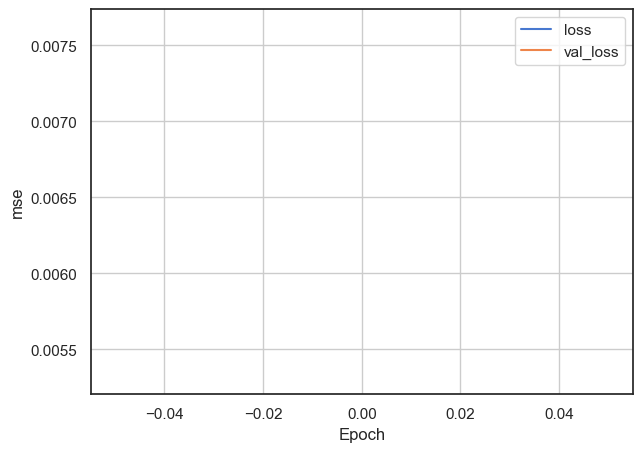

2/2 [==============================] - 0s 98ms/step - loss: 0.0076 - mse: 0.0076


[0.007637489587068558, 0.007637489587068558]

This model has a size of 0.029693603515625 MB
Creating the dataset from folder 02
Create the dataset with 2000 files requires 0.69 seconds.
The shape of val is (128, 64, 128, 1)


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\Fully_Convolutional_AE_MFCC\assets


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\Fully_Convolutional_AE_MFCC\assets


Best epoch: 1


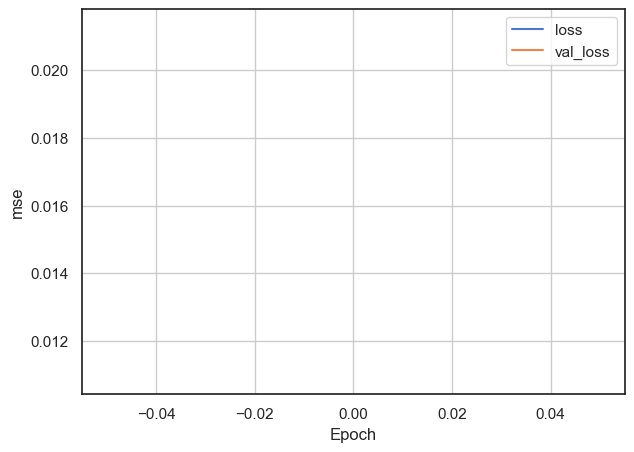

2/2 [==============================] - 0s 97ms/step - loss: 0.0112 - mse: 0.0112


[0.011150781996548176, 0.011150781996548176]

This model has a size of 0.029693603515625 MB


In [26]:
insert_by_hand = False

if insert_by_hand:
    best_params = {
        'n_layers':1,
        'n_units':16,
        'kernel_size':(7,7),
        'strides':(3,3),
        'max_pooling':(2,2),
        'code_channels':32,
        'activation':'elu',
        'drop_out':0,
        'batch_norm':True,
        'learning_rate':0.0116,
    }
else:
    file_path = os.path.join(main_dir, dir_name, 'Hyperband'+'_best_params')
    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)
        for key_double in ['kernel_size','strides','max_pooling']:
            best_params[key_double] = (best_params[key_double],best_params[key_double])


# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
verbose=3
if verbose>0:
    autoencoder.summary()
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()
    
epochs = 1 if not strong_pc else 100
n_folders = 2 if not strong_pc else 50 #then you can restart and train on more folders

US_training(AE_name = AE_name, autoencoder = autoencoder, epochs = epochs , n_folders=n_folders, preprocessing = preprocessing, ndim=3)

### Show the reconstruction capabilities of the model

Model: "Fully_Convolutional_AE_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 15, 31, 1)         10        
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        10        
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 120ms/step


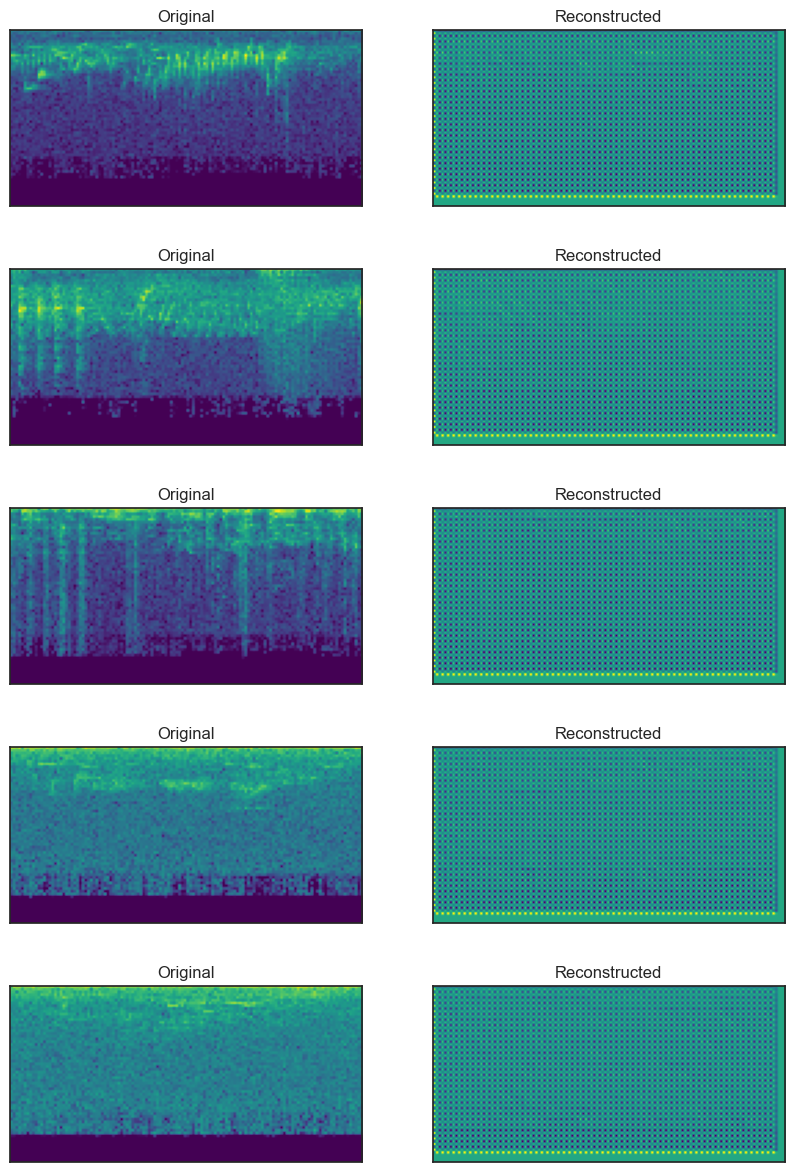

In [29]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)

Since there's less variability in the audio from unlabelled dataset we evaluate the autoencoder reconstruction on the labelled dataset.

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.
Model: "Fully_Convolutional_AE_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 15, 31, 1)         10        
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        10        
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 64ms/step


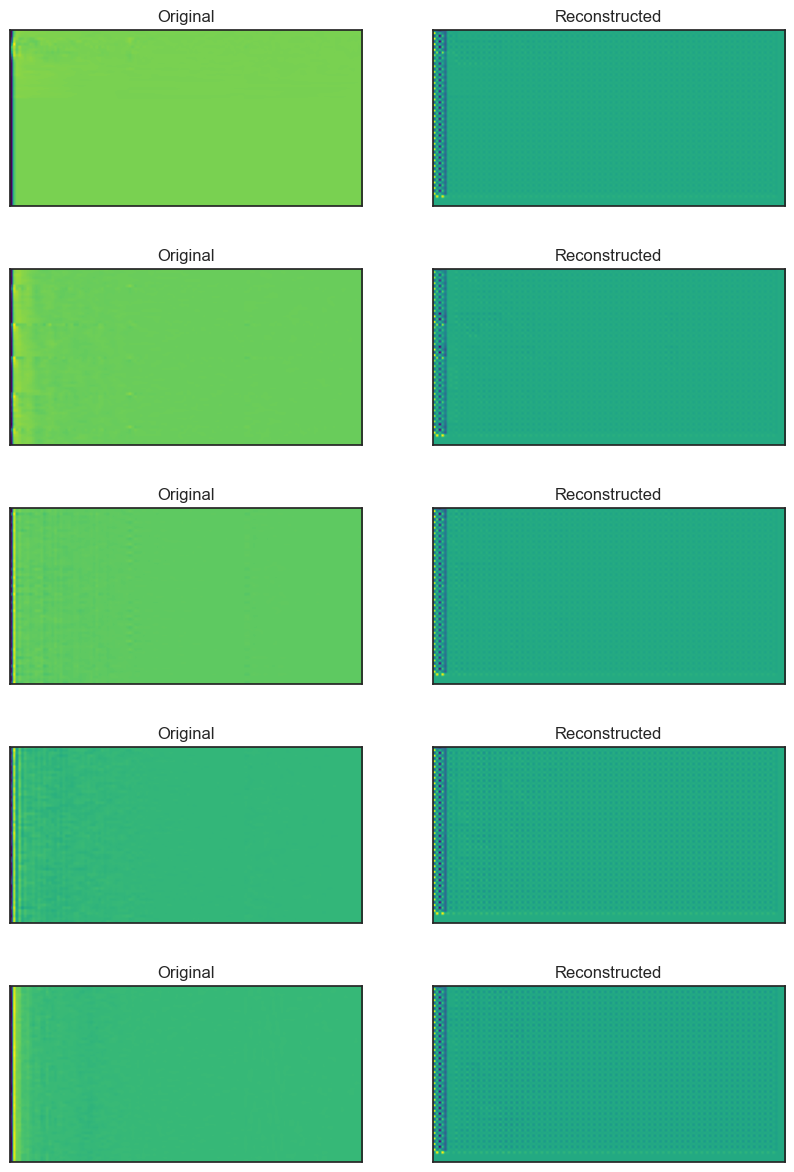

In [32]:

train, val, test, label_names = create_dataset( ESC10_path,
                                                verbose = 0,
                                                batch_size = 30,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT" or "MFCC"
                                                show_example_batch = False,
                                                ndim=3,
                                                resize = True,
                                                new_width = 64,
                                                new_height= 128)
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()
# show n original and reconstructed images
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)